In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
from ssm_em import StateSpaceEM

# Generate some data 

In [2]:
T = 1000
trange = numpy.arange(T)
Dx = 2
Dz = 1
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)

# Linear state space model 

In [25]:
sm = state_models.LinearStateModel(Dz, noise_z)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x)
om.pca_init(X)

In [26]:
ssm_em1 = StateSpaceEM(X, observation_model=om, state_model=sm)

Iteration 10 - llk=-43.8
Iteration 20 - llk=-43.2
EM did converge.


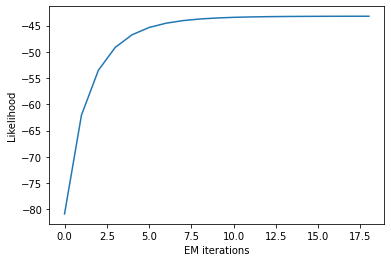

In [27]:
ssm_em1.run()
pyplot.plot(ssm_em1.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

Text(0.5, 0, 'Time steps')

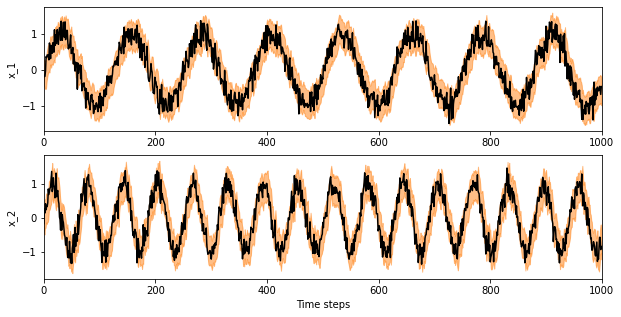

In [28]:
p_x = ssm_em1.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')

# State space model with non linear transition mean

In [19]:
Dk = 10
Dz = 2
sm = state_models.LSEMStateModel(Dz, Dk, noise_z)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x)
om.pca_init(X)

In [20]:
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm)

In [21]:
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

      fun: -48525.276386960824
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.50829835,  0.12684271,  1.22390036,  0.11906631, -0.6137657 ,
       -2.17795684, -0.16389983,  0.39773554,  2.28420123, -1.76107018,
       -1.31113147,  3.29371339, -4.08651134,  2.35845758,  1.62857848,
       -8.3360762 , -0.31411532, -2.49429227,  5.86732724,  2.0020107 ,
        2.95310266, -0.98495731,  0.31394189, -0.1816837 , -4.50229026,
        9.04497972, -4.59196091, -0.8829252 , -0.50541171, -2.0402565 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 58
      nit: 48
     njev: 58
   status: 0
  success: True
        x: array([-0.00206049, -0.00334777,  0.00465269,  0.01002798, -0.00572938,
       -0.00755211, -0.00892468,  0.00285411,  0.00969809,  0.00636967,
        0.01486385, -0.01337842,  0.0071618 , -0.01219819,  0.0123636 ,
        0.01073487, -0.00260759,  0.00145992,  0.00188985, -0.01092848,
       -0.01201213, -0.00637337, -0.

KeyboardInterrupt: 

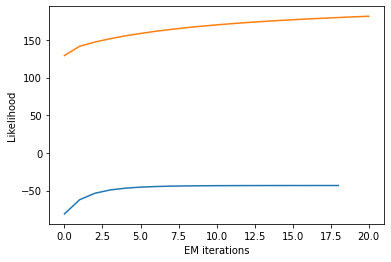

In [29]:
pyplot.plot(ssm_em1.llk_list[1:])
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

In [23]:
ssm_em.sm.A, ssm_em.sm.W

(array([[ 1.03025218e+00, -7.82570923e-02, -9.97311680e-01,
         -2.90827828e+01, -2.13305047e+01, -4.80793336e+01,
          1.32281194e+02,  1.27780424e+02, -8.60472413e+01,
         -5.27846779e+00,  2.51455155e+01, -9.43620408e+01],
        [ 2.91913895e-02,  9.50064639e-01, -7.04364391e+01,
         -1.31089352e+01, -3.84028805e+01, -1.02977212e+02,
          5.30155208e+01,  6.16545070e+00,  1.57556317e+02,
         -8.27825846e+01,  2.26157681e+02, -1.35136437e+02]]),
 <autograd.numpy.numpy_boxes.ArrayBox at 0x7ff1eea08dc0>)

Text(0.5, 0, 'Time steps')

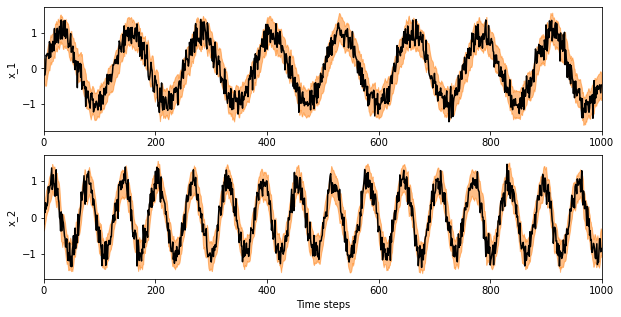

In [24]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')

In [8]:
smoothing_density =  ssm_em.smoothing_density
two_step_smoothing_density = ssm_em.twostep_smoothing_density
self = ssm_em.sm
self.state_density.w0 = self.W[:,0]
self.state_density.W = self.W[:,1:]
T = smoothing_density.R - 1
Ezz = smoothing_density.integrate('xx')
# E[z f(z)'] A'
v_joint = numpy.zeros([self.Dk, int(2 * self.Dz)])
v_joint[:,self.Dz:] = self.state_density.k_func.v
nu_joint = numpy.zeros([self.Dk, int(2 * self.Dz)])
nu_joint[:,self.Dz:] = self.state_density.k_func.nu
joint_k_func = factors.OneRankFactor(v=v_joint, nu=nu_joint, ln_beta=self.state_density.k_func.ln_beta)
Ezz_cross = two_step_smoothing_density.integrate('xx')[:,self.Dz:,:self.Dz]
Ekz = two_step_smoothing_density.multiply(joint_k_func).integrate('x').reshape((T,self.Dk,int(2*self.Dz)))[:,:,:self.Dz]
Ezf = numpy.concatenate([Ezz_cross, numpy.swapaxes(Ekz,1,2)], axis=2)
EzfA = numpy.einsum('abc,dc->bd', Ezf, self.A)
# A E[f(z)] b'
Ez = numpy.sum(smoothing_density.integrate('x')[:-1], axis=0)
Ek = numpy.sum(smoothing_density.multiply(self.state_density.k_func).integrate().reshape((T+1,self.Dk))[:-1], axis=0)
Ef = numpy.concatenate([Ez, Ek])
AEfb = numpy.dot(self.A, Ef)[:,None] * self.b[None]
# A E[f(z)f(z)'] A'
Ekk = smoothing_density.multiply(self.state_density.k_func).multiply(self.state_density.k_func).integrate().reshape((T+1, self.Dk, self.Dk))
Ekz = smoothing_density.multiply(self.state_density.k_func).integrate('x').reshape((T+1, self.Dk, self.Dz))
Eff = numpy.empty((self.Dphi, self.Dphi))
Eff[:self.Dz,:self.Dz] = numpy.sum(Ezz[:-1], axis=0)
Eff[self.Dz:,self.Dz:] = numpy.sum(Ekk[:-1], axis=0)
Eff[self.Dz:,:self.Dz] = numpy.sum(Ekz[:-1], axis=0)
Eff[:self.Dz,self.Dz:] = Eff[self.Dz:,:self.Dz].T
AEffA = numpy.dot(numpy.dot(self.A, Eff), self.A.T)
Qfunc_W = .5 * numpy.trace(numpy.dot(self.state_density.Lambda[0], - EzfA - EzfA.T + AEffA + AEfb + AEfb.T))

In [53]:
pz_k = two_step_smoothing_density.multiply(joint_k_func)

In [61]:
pz_k.integrate('Ax_a', A_mat=self.state_density.W[0], a_vec=self.state_density.w0[0])

ValueError: einstein sum subscripts string contains too many subscripts for operand 0

In [36]:
import auto

autograd.builtins.dict

In [91]:
A_mat = numpy.zeros((T*self.Dk, 1, pz_k.D))
A_mat[:,0,self.Dz:] = numpy.tile(self.state_density.W, (T,1))
a_vec = numpy.zeros((T*self.Dk, 1))
a_vec[:,0] = numpy.tile(self.state_density.w0, (T,))
pz_k.integrate('Ax_a', A_mat=A_mat, a_vec=a_vec)

(10000, 1)

In [73]:
W1 = numpy.tile(self.state_density.W[None], (T,1,1)).reshape((T*self.Dk, Dz))

In [74]:
A_mat[] = numpy.tile(self.state_density.W, (T,1))

In [87]:
.shape

(10000,)

In [10]:
pz_k = smoothing_density.slice(range(T)).multiply(self.state_density.k_func)
A_mat = numpy.tile(self.state_density.W, (T,1))[:,None]
a_vec = numpy.tile(self.state_density.w0, (T,))[:,None]
Edk_dW = numpy.sum(pz_k.integrate('Ax_aBx_b_outer', A_mat=A_mat, a_vec=a_vec).reshape((T,self.Dk,self.Dz)), axis=0)

In [59]:
pz_kk = pz_k.multiply(self.state_density.k_func)
A_mat = numpy.tile(self.state_density.W, (T * Dk, 1))[:,None]
a_vec = numpy.tile(self.state_density.w0, (T * Dk,))[:,None]
Edkk_dW = numpy.sum(pz_kk.integrate('Ax_aBx_b_outer', A_mat=A_mat, a_vec=a_vec).reshape((T,self.Dk,self.Dk,self.Dz)), axis=0)

In [60]:
Edkk_dW.shape

(10, 10, 2)

In [57]:
A_mat2 = numpy.tile(self.state_density.W[None,None,:], (T,self.Dk,1)).reshape((T * Dk * Dk, 1, Dz))

In [ ]:
numpy.alltrue(A_mat == A_mat2)

In [58]:
numpy.alltrue(numpy.equal(A_mat, A_mat2))

True

In [167]:
ssm_em.sm.W

array([[-1.69074091e-04,  1.06512348e-04, -5.39336985e-05],
       [ 1.30089708e-04, -8.94569390e-05, -2.05603578e-04],
       [ 1.94952943e-05,  2.09367516e-04,  7.71964537e-05],
       [-7.13172697e-05, -7.27920971e-05,  3.83596891e-05],
       [ 5.85122466e-05,  8.13932049e-05, -7.16290910e-05],
       [-6.11592365e-05, -4.11980756e-05, -2.14231652e-04],
       [-4.22254183e-05, -3.63963923e-05, -9.69604938e-05],
       [ 3.04610730e-05,  4.42938688e-06,  2.41068696e-05],
       [-3.31742346e-04, -1.35111125e-04, -4.91414925e-05],
       [-4.61909972e-05,  2.85077091e-05,  7.04910154e-06]])

In [152]:
#for t in range(T):
A_mat1 = numpy.tile(self.state_density.W, (1,1))[:,None]
a_vec1 = numpy.tile(self.state_density.w0, (1,))[:,None]
A_mat2 = numpy.tile(self.state_density.W, (Dk, 1))[:,None]
a_vec2 = numpy.tile(self.state_density.w0, (Dk,))[:,None]
A_mat3 = numpy.zeros((Dk, 1, 2 * Dz))
A_mat3[:, 0, Dz:] = self.state_density.W
Edk_dW = numpy.zeros((self.Dk, Dz))
Edk_dw0 = numpy.zeros((self.Dk, 1))
Ephi_dk_dW = numpy.zeros((self.Dphi, self.Dk, Dz))
Ephi_dk_dw0 = numpy.zeros((self.Dphi, self.Dk, 1))
Ezdk_dW = numpy.zeros((self.Dk, self.Dz, Dz))
Ezdk_dw0 = numpy.zeros((self.Dk, self.Dz, 1))
for t in range(T):
    p_t = smoothing_density.slice([t])
    p_t_k = p_t.multiply(self.state_density.k_func)
    Edk_dW += p_t_k.integrate('Ax_aBx_b_outer', A_mat=A_mat1, a_vec=a_vec1).reshape((1,self.Dk,self.Dz))[0]
    Edk_dw0 += p_t_k.integrate('Ax_a', A_mat=A_mat1, a_vec=a_vec1)
    p_t_kk = p_t_k.multiply(self.state_density.k_func)
    Ephi_dk_dW[:Dz] += numpy.swapaxes(p_t_k.integrate('xAx_ax', A_mat=self.state_density.W[:,None], a_vec=self.state_density.w0[:,None]), axis1=0, axis2=1)
    Ephi_dk_dw0[:Dz] += numpy.swapaxes(p_t_k.integrate('Ax_aBx_b_outer', B_mat=self.state_density.W[:,None], b_vec=self.state_density.w0[:,None]), axis1=0, axis2=1)
    Ephi_dk_dW[Dz:] += p_t_kk.integrate('Ax_aBx_b_outer', A_mat=A_mat2, a_vec=a_vec2).reshape((self.Dk, self.Dk, self.Dz))
    Ephi_dk_dw0[Dz:] += p_t_kk.integrate('Ax_a', A_mat=A_mat2, a_vec=a_vec2).reshape((self.Dk, self.Dk, 1))
    p_tt = two_step_smoothing_density.slice([t])
    p_tt_k = p_tt.multiply(joint_k_func)
    Ezdk_dW += p_tt_k.integrate('xAx_ax', A_mat=A_mat3, a_vec=a_vec1)[:,:Dz,Dz:]
    Ezdk_dw0 += p_tt_k.integrate('Ax_aBx_b_outer', B_mat=A_mat3, b_vec=a_vec1)[:,:Dz]
Edk_dW = numpy.concatenate([Edk_dw0, Edk_dW], axis=1)
Ephi_dk_dW = numpy.concatenate([Ephi_dk_dw0, Ephi_dk_dW], axis=2)
Ezdk_dW = numpy.concatenate([Ezdk_dw0, Ezdk_dW], axis=2)
AEphi_dk_dW = numpy.einsum('ab,bcd->cad',self.A, Ephi_dk_dW)   
bEdk_dW = Edk_dW[:,None] * self.b[None,:,None]
dW = numpy.einsum('ab,bac->bc', self.A[:,self.Dz:], 
                     numpy.einsum('ab,cbd->cad', self.Qz_inv, 
                                  (Ezdk_dW - AEphi_dk_dW - bEdk_dW)))

In [153]:
dW

array([[-1.58050385e-06,  9.73259756e-06, -1.71906075e-05],
       [ 3.60518816e-07, -1.03733270e-05,  4.17575363e-06],
       [-3.77848012e-07, -6.28484119e-06, -3.76803689e-06],
       [-8.46286849e-08,  1.04064600e-05, -1.24040164e-06],
       [ 2.10006444e-07, -6.33920697e-06,  2.43754901e-06],
       [ 5.51359419e-07, -9.41514369e-06,  6.15258976e-06],
       [ 9.90503231e-07, -1.05015061e-05,  1.08782588e-05],
       [ 8.02090974e-07, -6.48825306e-06,  8.74651617e-06],
       [ 1.54115126e-07,  1.38764601e-06,  1.62210164e-06],
       [ 9.27110188e-07,  3.04783117e-06,  9.87513144e-06]])

In [145]:
(Ezdk_dW - AEphi_dk_dW - bEdk_dW).shape

(10, 2, 3)

In [107]:
p_t_k.integrate('Ax_a', _mat=A_mat1, a_vec=a_vec1).shape

(10, 1)

In [118]:
Ephi_dk_dw0[Dz:].shape

(10, 10, 1)

In [125]:
p_tt_k.integrate('Ax_aBx_b_outer', B_mat=A_mat3, b_vec=a_vec1).shape

(10, 4, 1)

In [131]:
Ezdk_dW = numpy.concatenate([Ezdk_dw0, Ezdk_dW], axis=2)

array([[[ 1.05590982e-01,  3.15015172e-02,  3.64125839e-03],
        [-2.67678302e-02, -3.45647979e-03,  2.80606844e-02]],

       [[-2.39375682e-02, -1.40271602e-02, -2.02147432e-03],
        [ 5.19337893e-02, -3.08228756e-04, -1.12899892e-02]],

       [[ 2.66216174e-02, -1.00169918e-01, -2.70862314e-03],
        [ 4.71474904e-02, -4.30946987e-03, -8.89845813e-02]],

       [[ 5.29881479e-03,  2.51912882e-02,  1.99168889e-03],
        [-5.78297026e-02,  1.49718369e-03,  2.11329318e-02]],

       [[-1.39983898e-02, -3.16291400e-03, -1.09920206e-03],
        [ 3.16452556e-02, -9.78844846e-05, -2.01795943e-03]],

       [[-3.72420916e-02,  2.56834625e-02, -1.18568420e-03],
        [ 4.10355326e-02,  1.36196689e-03,  2.41949100e-02]],

       [[-6.65958048e-02,  1.73016090e-02, -1.98282490e-03],
        [ 3.93848057e-02,  2.51796125e-03,  1.64781162e-02]],

       [[-5.39503669e-02,  1.81112751e-02, -1.25274937e-03],
        [ 2.03581397e-02,  2.36561782e-03,  1.67211328e-02]],

       [